# Circle detection - v1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import scipy.ndimage as ndi

Loading the image and verifying it's with 3 channels

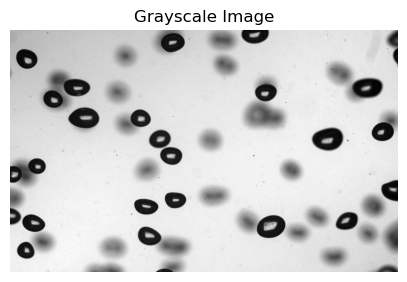

In [3]:
# Load the image
image = io.imread("/Users/noedaniel/Desktop/Image Processing/frame_000030.tif")

if image.ndim == 3:
    image_gray = color.rgb2gray(image)
else:
    image_gray = image

plt.figure(figsize=(5, 5))
plt.imshow(image_gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

### Thresholding phase

Threshold (the values need to be tested before on ImageJ to remove under surface bubbles). We do a over/under threshold (like on ImageJ)

/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_53061/2546955169.py:7: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  over_under_threshold_image[image_gray < lower_threshold] = -1


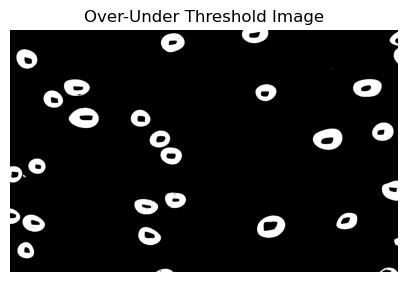

In [4]:
# Define the lower and upper threshold values
lower_threshold = 60
upper_threshold = 255

over_under_threshold_image = np.zeros_like(image_gray)
over_under_threshold_image[image_gray > upper_threshold] = 1
over_under_threshold_image[image_gray < lower_threshold] = -1

plt.figure(figsize=(5, 5))
plt.imshow(over_under_threshold_image, cmap='gray')
plt.title("Over-Under Threshold Image")
plt.axis('off')
plt.show()

### Canny filtering.

Once the tresholding is done, we apply Canny filter

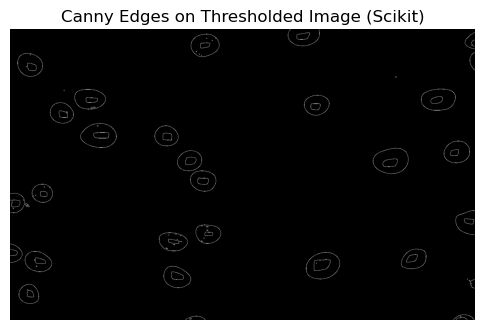

In [5]:
from skimage.feature import canny

# Perform Canny edge detection
edges_canny_skimage = canny(over_under_threshold_image.astype(float), sigma=1.0)

plt.figure(figsize=(6, 6))
plt.imshow(edges_canny_skimage, cmap='gray')
plt.title("Canny Edges on Thresholded Image (Scikit)")
plt.axis("off")
plt.show()

Highlighting edges, we get

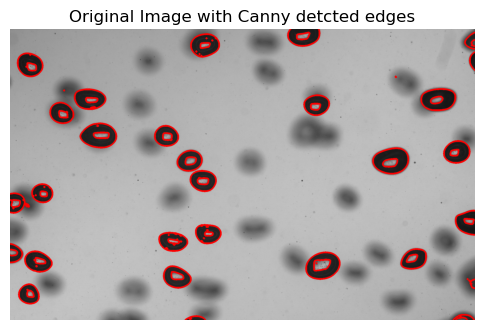

In [6]:
# Create a copy of the original image to draw on and convert to RGB
overlay_image = np.stack([image] * 3, axis=-1)

# Increase the thickness of the edges
thick_edges = ndi.binary_dilation(edges_canny_skimage, iterations=3)

# Set the red color for the edges
overlay_image[thick_edges] = [255, 0, 0]

plt.figure(figsize=(6, 6))
plt.imshow(overlay_image)
plt.title("Original Image with Canny detcted edges")
plt.axis("off")
plt.show()

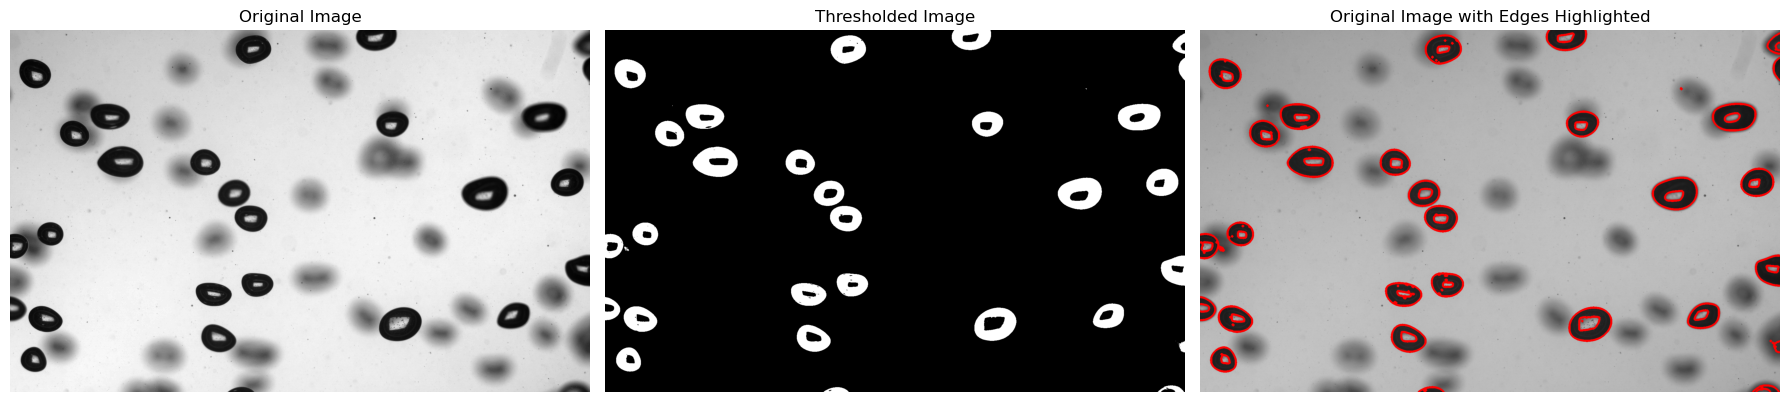

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(over_under_threshold_image, cmap='gray')
axes[1].set_title("Thresholded Image")
axes[1].axis('off')

axes[2].imshow(overlay_image)
axes[2].set_title("Original Image with Edges Highlighted")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Filling the bubbles

Let's use `binary_fill_holes`to improve the process

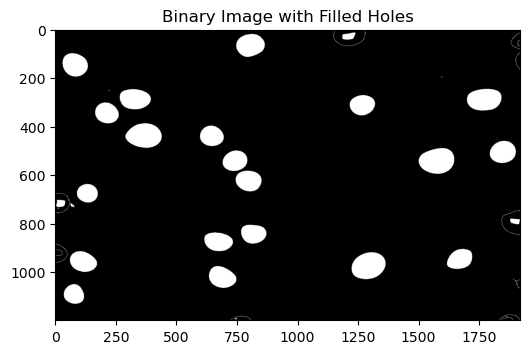

In [8]:
filled_image = ndi.binary_fill_holes(edges_canny_skimage)

# Visualize the filled binary image
plt.figure(figsize=(6, 6))
plt.imshow(filled_image, cmap='gray')
plt.title("Binary Image with Filled Holes")
plt.axis()
plt.show()

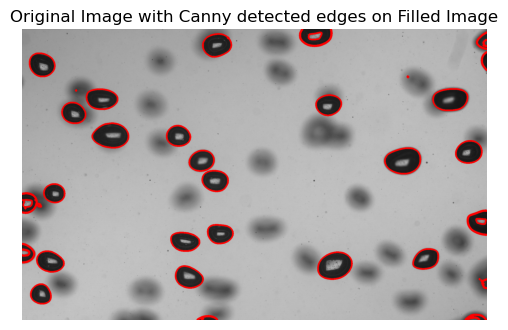

In [9]:
# Perform Canny edge detection on the filled image
edges_canny_filled = canny(filled_image.astype(float), sigma=1.0)

# Increase the thickness of the edges
thick_edges_filled = ndi.binary_dilation(edges_canny_filled, iterations=3)

# Create a copy of the original image to draw on and convert to RGB
overlay_image_filled = np.stack([image] * 3, axis=-1)

# Set the red color for the edges
overlay_image_filled[thick_edges_filled] = [255, 0, 0]

plt.figure(figsize=(6, 6))
plt.imshow(overlay_image_filled)
plt.title("Original Image with Canny detected edges on Filled Image")
plt.axis("off")
plt.show()

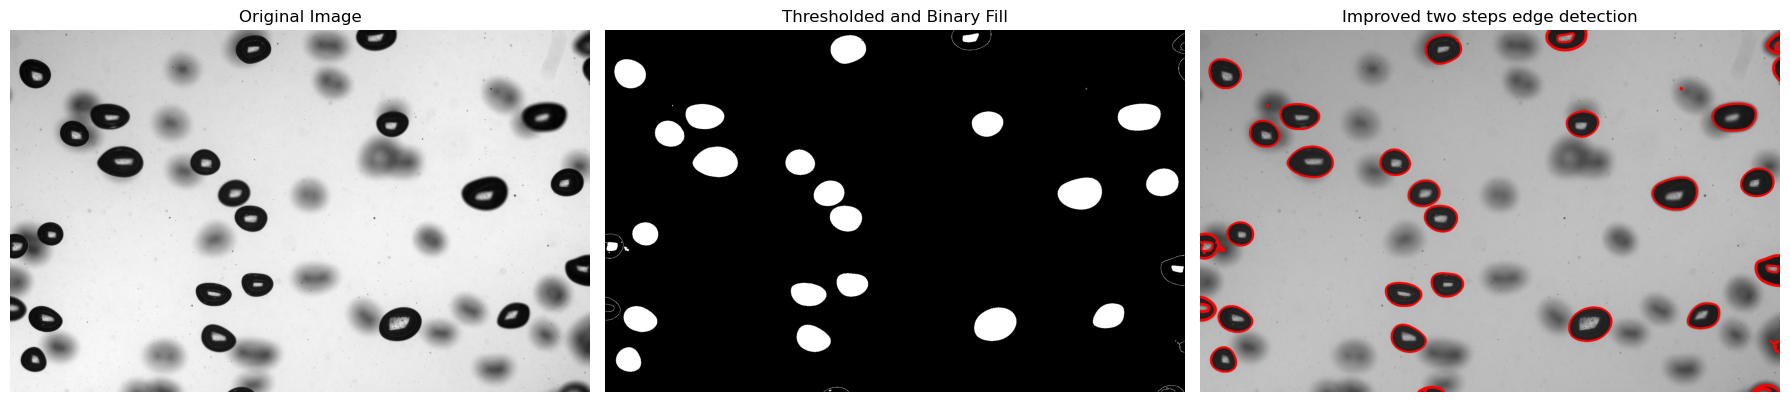

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(filled_image, cmap='gray')
axes[1].set_title("Thresholded and Binary Fill")
axes[1].axis('off')

axes[2].imshow(overlay_image_filled)
axes[2].set_title("Improved two steps edge detection")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Hough transform

First let's start back from the edged image

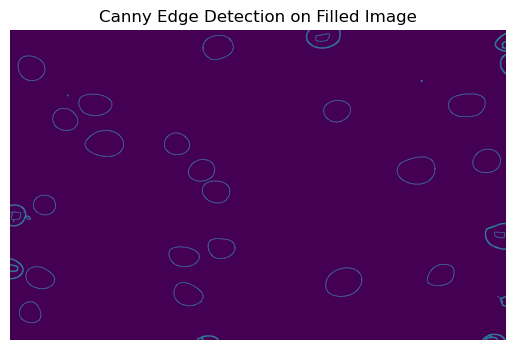

In [16]:
plt.imshow(edges_canny_filled, cmap='viridis')
plt.axis('off')
plt.title('Canny Edge Detection on Filled Image')
plt.show()

Let's do the Hough transform on this now for circles.

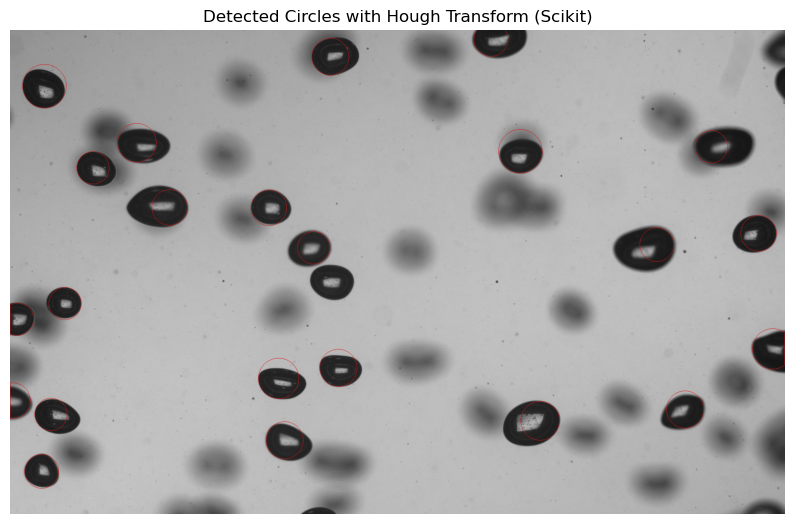

In [48]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

# Define the radius range for the circles
hough_radii = np.arange(40, 200, 2)

# Perform Hough transform for circles
hough_res = hough_circle(edges_canny_filled, hough_radii)

# Select the most prominent circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=90, min_ydistance=90, threshold=0.2)

# Visualize the detected circles
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
image_with_circles = color.gray2rgb(image_gray)

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    circy = np.clip(circy, 0, image_with_circles.shape[0] - 1)
    circx = np.clip(circx, 0, image_with_circles.shape[1] - 1)
    image_with_circles[circy, circx] = (220, 20, 20)

ax.imshow(image_with_circles, cmap=plt.cm.gray)
plt.title("Detected Circles with Hough Transform (Scikit)")
plt.axis('off')
plt.show()

In [49]:
print(len(cx), "circles detected")

23 circles detected


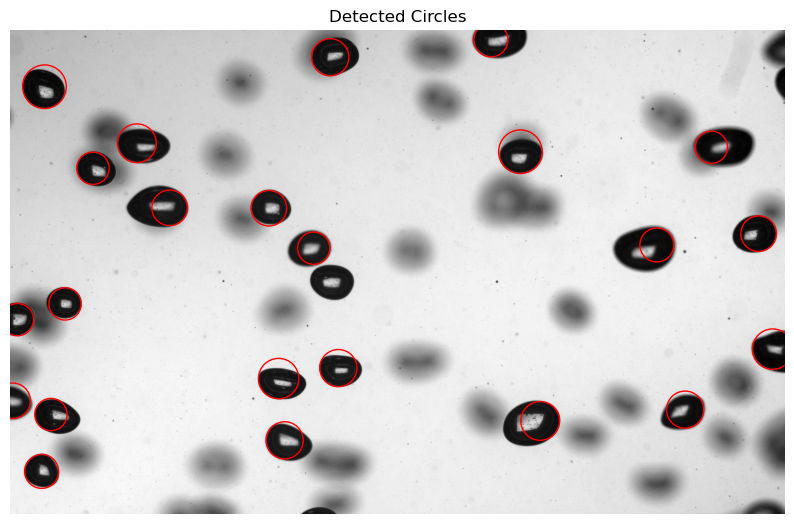

In [50]:
plt.figure(figsize=(10, 10))
plt.imshow(image_gray, cmap='gray')
plt.title("Detected Circles")

for center_y, center_x, radius in zip(cy, cx, radii):
    circle = plt.Circle((center_x, center_y), radius, color='red', fill=False)
    plt.gca().add_patch(circle)

plt.axis('off')
plt.show()

### Recap

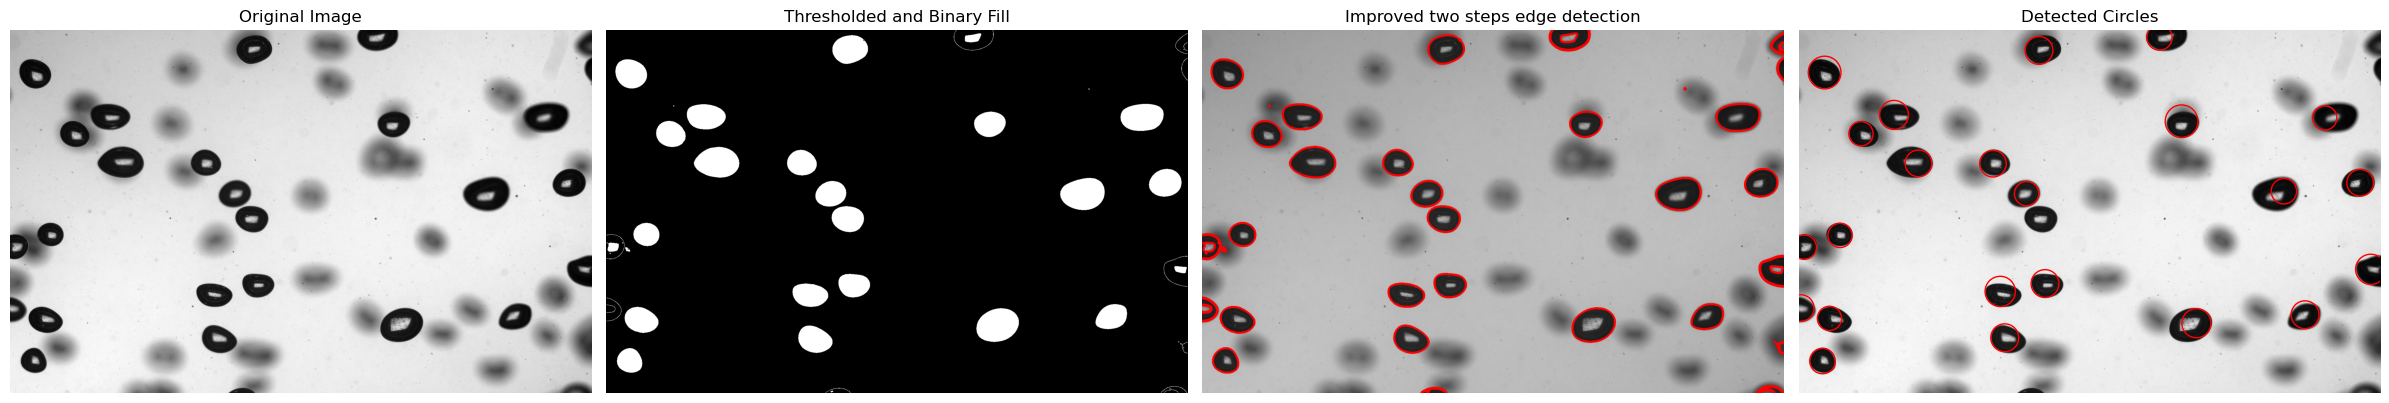

In [51]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(filled_image, cmap='gray')
axes[1].set_title("Thresholded and Binary Fill")
axes[1].axis('off')

axes[2].imshow(overlay_image_filled)
axes[2].set_title("Improved two steps edge detection")
axes[2].axis('off')

axes[3].imshow(image_gray, cmap='gray')
axes[3].set_title("Detected Circles")
for center_y, center_x, radius in zip(cy, cx, radii):
    circle = plt.Circle((center_x, center_y), radius, color='red', fill=False)
    axes[3].add_patch(circle)
axes[3].axis('off')

plt.tight_layout()
plt.show()